# Concept Similarity

Our second hypothesis tests the effect of degree of misunderstanding on the magnitude of effort. 

We operationalize degree of misunderstanding as a conceptual similarity between target concept and answer offered by a guesser. To have a reproducible measure of conceptual similarity, we use the ConceptNet Numberbatch embeddings (REF). Alongside, in online anonymous rating study, we have collected data from XX people (XX English, XX Dutch) who were asked to rate the similarity between each pair of words. We then compare the 'perceived similarity' with cosine similarity computed from ConceptNet embeddings, to validate the use of ConceptNet embeddings as a measure of conceptual similarity.


In [ ]:
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin

curfolder = os.getcwd()
rawdata = curfolder + '\\..\\00_RAWDATA\\'
answerfiles = glob.glob(rawdata + '*\\*.csv', recursive=True)
datafolder = curfolder + '\\data\\'

# load all files that have '_1_results' in the name 
answerfiles_1 = [f for f in answerfiles if '_1_results' in f]
# loop over list and add it into one big df
df_all1 = pd.DataFrame()
for file in answerfiles_1:
    df = pd.read_csv(file)
    df_all1 = pd.concat([df_all1, df], ignore_index=True)

df_all1['exp'] = 1 

# load all files that have '_2_results' in the name
answerfiles_2 = [f for f in answerfiles if '_2_results' in f]
# loop over list and add it into one big df
df_all2 = pd.DataFrame()
for file in answerfiles_2:
    df = pd.read_csv(file)
    df_all2 = pd.concat([df_all2, df], ignore_index=True)

df_all2['exp'] = 2

# merge dfs
df_all = pd.concat([df_all1, df_all2], ignore_index=True)

# keep only columns word and answer
df = df_all[['word', 'answer', 'exp']]

First we need to do some data-wrangling to get all in the right format for the embedding extraction and comparison

In [105]:
# concept list
df_concepts = pd.read_excel(rawdata + '/conceptlist_info.xlsx')

# in df_concepts, keep only English and Dutch
df_concepts = df_concepts[['English', 'Dutch']]

# rename Dutch to word
df_concepts = df_concepts.rename(columns={'Dutch': 'word'})

# merge df and df_concepts on word
df = pd.merge(df, df_concepts, on='word', how='left')

# show rows where English is NaN
df[df['English'].isnull()]

# add translations manually for each (these are practice trials)
df.loc[df['word'] == 'bloem', 'English'] = 'flower'
df.loc[df['word'] == 'dansen', 'English'] = 'to dance'
df.loc[df['word'] == 'auto', 'English'] = 'car'
df.loc[df['word'] == 'olifant', 'English'] = 'elephant'
df.loc[df['word'] == 'comfortabel', 'English'] = 'comfortable'
df.loc[df['word'] == 'bal', 'English'] = 'ball'
df.loc[df['word'] == 'haasten', 'English'] = 'to hurry'
df.loc[df['word'] == 'gek', 'English'] = 'crazy'
df.loc[df['word'] == 'snijden', 'English'] = 'to cut'
df.loc[df['word'] == 'koken', 'English'] = 'to cook'
df.loc[df['word'] == 'juichen', 'English'] = 'to cheer'
df.loc[df['word'] == 'zingen', 'English'] = 'to sing'
df.loc[df['word'] == 'glimlach', 'English'] = 'smile'
df.loc[df['word'] == 'klok', 'English'] = 'clock'
df.loc[df['word'] == 'fiets', 'English'] = 'bicycle'
df.loc[df['word'] == 'vliegtuig', 'English'] = 'airplane'
df.loc[df['word'] == 'geheim', 'English'] = 'secret'
df.loc[df['word'] == 'telefoon', 'English'] = 'telephone'
df.loc[df['word'] == 'zwaaien', 'English'] = 'to wave'
df.loc[df['word'] == 'sneeuw', 'English'] = 'snow'

# make a list of English answers
answers_en = ['party', 'to cheer', 'tasty', 'to shoot', 'to breathe', 'zombie', 'bee', 'sea', 'dirty', 'tasty', 'car', 'to eat', 'to eat', 'to blow', 'hose', 'hose', 'to annoy', 'to make noise', 'to make noise', 'to run away', 'elephant', 'to cry', 'cold', 'outfit', 'silence', 'to ski', 'wrong', 'to play basketball', 'to search', 'disturbed', 'to run', 'to lick', 'to lift', 'lightning', 'to think', 'to jump', 'to fall', 'to write', 'to dance', 'shoulder height', 'horn', 'dirty', 'boring', 'to drink', 'strong', 'elderly', 'to mix', 'fish', 'fish', 'dirty', 'wrong', 'smart', 'to box', 'to box', 'dog', 'to catch', 'to cheer', 'to sing', 'pregnant', 'hair', 'to shower', 'pain', 'burnt', 'hot', 'I', 'to chew', 'bird', 'airplane', 'to fly', 'to think', 'to choose', 'to doubt', 'graffiti', 'fireworks', 'bomb', 'to smile', 'to laugh', 'smile', 'clock', 'to wonder', 'height', 'big', 'height', 'space', 'to misjudge', 'to wait', 'satisfied', 'happy', 'fish', 'to smell', 'wind', 'pain', 'to burn', 'hot', 'to cycle', 'to fly', 'airplane', 'bird', 'to crawl', 'to drink', 'waterfall', 'water', 'fire', 'top', 'good', 'to hear', 'to point', 'distance', 'there', 'to whisper', 'quiet', 'to be silent', 'telephone', 'to blow', 'to distribute', 'to give', 'cat', 'to laugh', 'tasty', 'to eat', 'yummy', 'to sleep', 'mountain', 'dirty', 'to vomit', 'to be disgusted', 'to greet', 'hello', 'goodbye', 'to smell', 'nose', 'odor', 'to fly', 'fireworks', 'to blow', 'to cut', 'pain', 'hot', 'to slurp', 'to throw', 'to fall', 'to fall', 'whistle', 'heartbeat', 'mouse', 'to hit', 'to catch', 'to grab', 'to throw', 'to fall', 'to shoot', 'circus', 'trunk', 'to fall', 'to fight', 'pain', 'to push open', 'to growl', 'to cut', 'to eat', 'knife', 'to slurp', 'to drink', 'drink', 'to eat', 'delicious', 'tasty', 'to cough', 'sick', 'to cry', 'to cry']

# replace skien with skiën in the df
df['answer'] = df['answer'].str.replace('skien', 'skiën')

# get rid of English 'to beat'
df_final = df[df['English'] != 'to beat']
# and to weep
df_final = df[df['English'] != 'to weep']

# add those to df as answers_en
df['answer_en'] = answers_en

# make a list of English targets
meanings_en = list(df['English'])
# Dutch targets
meanings_nl = list(df['word'])
# Dutch answers
answers_nl = list(df['answer'])

df.head(15)


,word,answer,exp,English,answer_en
0,bloem,feest,1,flower,party
1,dansen,juichen,1,to dance,to cheer
2,bitter,lekker,1,bitter,tasty
3,vechten,schieten,1,to fight,to shoot
4,ademen,ademen,1,to breathe,to breathe
5,bijten,zombie,1,to bite,zombie
6,zoemen,bij,1,buzz,bee
7,fluisteren,zee,1,to whisper,sea
8,walgen,vies,1,disgusted,dirty
9,langzaam,lekker,1,slow,tasty


Now we will load in ConceptNet numberbatch (version XX) and compute cosine similarity for each pair

In [97]:
# Load embeddings from a file
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


We will use multilingual numberbatch to extract words in the original language of experiment - Dutch. While English has better representation in ConceptNet, the English numberbatch does not make distinction between nouns and verbs (so 'a drink' and 'to drink' have common representation - drink). Because this is important distinction for us, we opt for Dutch embeddings to avoid this problem

In [120]:
# load embeddings
embeddings = load_embeddings('numberbatch\\numberbatch.txt') # downloaded from https://github.com/commonsense/conceptnet-numberbatch?tab=readme-ov-file
#embeddings_en = load_embeddings('numberbatch-en.txt') # downloaded from https://github.com/commonsense/conceptnet-numberbatch?tab=readme-ov-file

# this is how words are represented
vec_nl = embeddings.get('/c/nl/skiën')
print(vec_nl)


[ 3.410e-02 -4.640e-02  5.490e-02  1.544e-01  1.800e-02 -5.050e-02
 -6.660e-02 -2.300e-02  5.320e-02  1.104e-01  2.770e-02  5.040e-02
 -2.010e-02  5.900e-03 -1.133e-01 -9.370e-02 -7.890e-02  3.540e-02
  3.780e-02  8.400e-02 -3.880e-02  7.680e-02 -8.010e-02  6.540e-02
 -1.493e-01 -1.036e-01  8.490e-02  1.040e-02 -6.890e-02  6.890e-02
  1.226e-01 -1.850e-02  1.520e-02  2.810e-02 -5.660e-02 -2.670e-02
 -5.700e-02 -4.480e-02  1.924e-01  5.800e-02 -7.800e-02 -7.700e-03
  1.132e-01  6.350e-02 -4.310e-02  1.900e-03 -4.820e-02  1.047e-01
  6.900e-02  7.150e-02  1.660e-02  2.730e-02  4.340e-02  1.130e-02
 -1.427e-01 -9.200e-03 -8.000e-04  2.310e-02  1.234e-01 -1.452e-01
 -1.710e-02 -1.094e-01 -1.518e-01  4.820e-02  1.400e-02 -1.460e-02
  1.023e-01  5.220e-02  1.362e-01  3.190e-02 -2.590e-02  1.220e-01
  1.750e-02  8.810e-02 -9.200e-02 -1.226e-01 -5.560e-02 -6.600e-03
  3.180e-02 -1.113e-01  6.130e-02 -1.202e-01 -2.480e-02 -8.300e-03
 -1.710e-02  3.410e-02  1.550e-02 -8.000e-02 -6.390e-02  1.170

Now we take the list of target-answer pairs, transform them into embedding format and perform cosine similarity.

There will probably be some answers that will not be represented in the numberbatch (e.g., if the answer has more than one word). So we will need to think about how to handle these.

In [106]:
# get the embeddings for the words in the list meanings_en
word_embeddings_t = {}
for word in meanings_nl:
    word_embed = '/c/nl/' + word
    if word_embed in embeddings:
        word_embeddings_t[word] = embeddings[word_embed]

# get the embeddings for the words in the list answers_en
word_embeddings_ans = {}
for word in answers_nl:
    word_embed = '/c/nl/' + word
    if word_embed in embeddings:
        word_embeddings_ans[word] = embeddings[word_embed]

# calculate the similarity between the first word in the list meanings_en and first word in answers_en, second word in meanings_en and second word in answers_en, etc.
cosine_similarities = []

for i in range(len(meanings_nl)):
    word1 = meanings_nl[i]
    word2 = answers_nl[i]
    vec1 = word_embeddings_t.get(word1)
    vec2 = word_embeddings_ans.get(word2)
    if vec1 is not None and vec2 is not None:
        cosine_sim = cosine_similarity(vec1, vec2)
        cosine_similarities.append(cosine_sim)
    else:
        # print which concepts could not be found
        if vec1 is None:
            print(f"Concept not found: {word1}")
        if vec2 is None:
            print(f"Concept not found: {word2}")
        cosine_similarities.append(None)

df['cosine_similarity'] = cosine_similarities
df_final.to_csv(datafolder + 'conceptnet_clean.csv', index=False)
df.head(15)


Concept not found: lawaai maken
Concept not found: lawaai maken
Concept not found: schouderhoogte
Concept not found: openduwen


,word,answer,exp,English,answer_en,cosine_similarity
0,bloem,feest,1,flower,party,0.135571
1,dansen,juichen,1,to dance,to cheer,0.177888
2,bitter,lekker,1,bitter,tasty,0.257505
3,vechten,schieten,1,to fight,to shoot,0.205791
4,ademen,ademen,1,to breathe,to breathe,1.000000
5,bijten,zombie,1,to bite,zombie,0.068596
6,zoemen,bij,1,buzz,bee,0.164508
7,fluisteren,zee,1,to whisper,sea,0.072605
8,walgen,vies,1,disgusted,dirty,0.353700
9,langzaam,lekker,1,slow,tasty,0.077073


# Comparing cosine similarity against perceived similarity

To validate the use of ConceptNet embeddings as a measure of conceptual similarity, we compare the cosine similarity computed from ConceptNet embeddings with the 'perceived similarity' ratings collected in the online anonymous rating study. We use Pearson correlation to compare the two measures.

In [107]:
# load in excel similarity_en_survey
df_survey = pd.read_excel(datafolder + '\\similarity_en_survey.xlsx')

# get rid of Timestamp column
df_survey = df_survey.drop(columns='Timestamp')

# for each column, calculate the mean and save it to a df
df_survey_means = pd.DataFrame(df_survey.mean()).reset_index()

# separate the index, the first part is English, the second part is the answer_en
df_survey_means['English'] = df_survey_means['index'].str.split(' - ').str[0]
df_survey_means['answer_en'] = df_survey_means['index'].str.split(' - ').str[1]

# get rid of the index column
df_survey_means = df_survey_means.drop(columns='index')

# rename the column 0 to mean_similarity
df_survey_means = df_survey_means.rename(columns={0: 'mean_similarity'})

# change to lightning into lightning
df_survey_means.loc[df_survey_means['answer_en'] == 'to lightning', 'answer_en'] = 'lightning'
# phone to telephone
df_survey_means.loc[df_survey_means['answer_en'] == 'phone', 'answer_en'] = 'telephone'
# scent to odor
df_survey_means.loc[df_survey_means['answer_en'] == 'scent', 'answer_en'] = 'odor'

df_survey_means.head(15)

,mean_similarity,English,answer_en
0,2.1,flower,party
1,3.6,to dance,to cheer
2,3.0,bitter,tasty
3,5.1,to fight,to shoot
4,10.0,to breathe,to breathe
5,4.8,to bite,zombie
6,6.0,buzz,bee
7,0.9,to whisper,sea
8,4.4,disgusted,dirty
9,0.9,slow,tasty


In [ ]:
# merge df_survey_means with df on English and answer_en
df_final = pd.merge(df, df_survey_means, on=['English', 'answer_en'], how='left')

# get rid of English 'to beat'
df_final = df_final[df_final['English'] != 'beat']
# and to weep
df_final = df_final[df_final['English'] != 'weep']

# show me the rows where mean_similarity is NaN
df_final[df_final['mean_similarity'].isnull()]

# mean_similarity of row where English is sharp and answer_en is pain is 4.0 (don't know why it's NaN)
df_final.loc[(df_final['English'] == 'sharp') & (df_final['answer_en'] == 'pain'), 'mean_similarity'] = 4.0

# save it
df_final.to_csv(datafolder + '/df_final_conceptnet.csv', index=False)

df_final.head(15)

,word,answer,exp,English,answer_en,cosine_similarity,mean_similarity
0,bloem,feest,1,flower,party,0.135571,2.1
1,dansen,juichen,1,to dance,to cheer,0.177888,3.6
2,bitter,lekker,1,bitter,tasty,0.257505,3.0
3,vechten,schieten,1,to fight,to shoot,0.205791,5.1
4,ademen,ademen,1,to breathe,to breathe,1.000000,10.0
5,bijten,zombie,1,to bite,zombie,0.068596,4.8
6,zoemen,bij,1,buzz,bee,0.164508,6.0
7,fluisteren,zee,1,to whisper,sea,0.072605,0.9
8,walgen,vies,1,disgusted,dirty,0.353700,4.4
9,langzaam,lekker,1,slow,tasty,0.077073,0.9


Now we can finally run correlation

                   X                Y   method alternative    n         r  \
0  cosine_similarity  mean_similarity  pearson   two-sided  120  0.725477   

         CI95%         p-unc       BF10  power  
0  [0.63, 0.8]  7.161837e-21  7.724e+17    1.0  


<Figure size 1000x600 with 0 Axes>

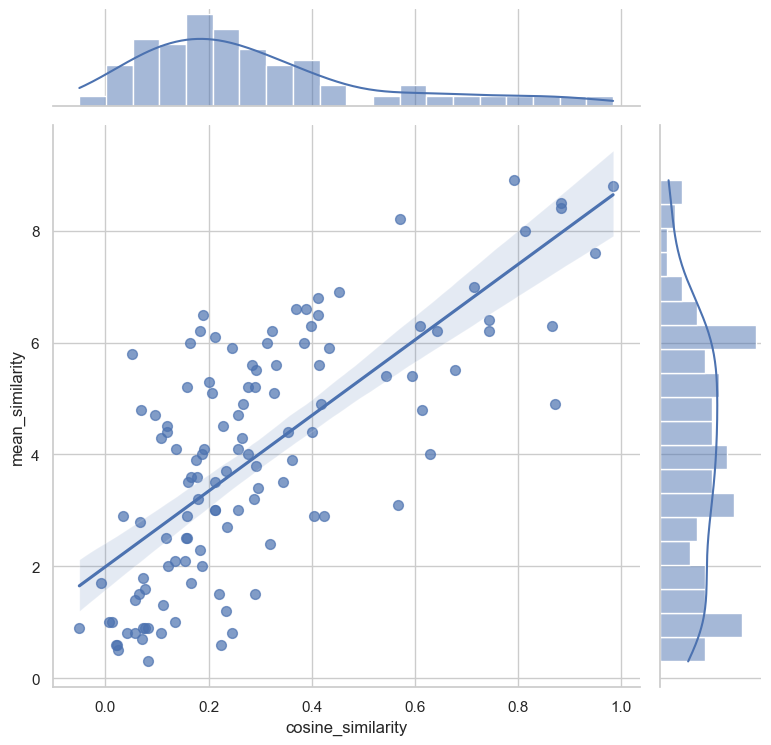

In [ ]:
# get rid of all lines where mean_similarity is 10.0
df_corr = df_final[df_final['mean_similarity'] != 10.0]

feature1 = "cosine_similarity"
feature2 = "mean_similarity"

# create a sub-dataframe with the selected features, dropping missing values
subdf = df_corr[[feature1, feature2]].dropna()

# compute the correlation coefficient, with Bayes factor
corr_with_bf = pingouin.pairwise_corr(subdf, columns=['cosine_similarity', 'mean_similarity'], method='pearson', alternative='two-sided')
print(corr_with_bf)

# create a joint plot with scatter and marginal histograms
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# scatter plot with histograms
g = sns.jointplot(x=subdf[feature1], y=subdf[feature2], kind='reg', height=8,
                  scatter_kws={'s': 50, 'alpha': 0.7}, marginal_kws=dict(bins=20, fill=True))

g.fig.subplots_adjust(top=0.93)  # Adjust the title position

# show plot
plt.show()

# save with high dpi
plot_name = f"{feature1}_vs_{feature2}_jointplot.png"
g.savefig(plot_name, dpi=300)
